In [37]:


!pip install transformers

https://github.com/almarengo/gpt2-text-classification/blob/main/GPT2_Transfer_Learning_final.ipynb


In [38]:
import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model
from sklearn.model_selection import train_test_split

In [39]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [40]:
!pip install -q transformers
!pip install -q simpletransformers
!pip install -q datasets

In [41]:
import pandas as pd
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
#aset_train.rename_column_('label', 'labels')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
#dataset_test.rename_column_('label', 'labels')
test_df=pd.DataFrame(dataset_test)

In [42]:
# Concatenate train and test DataFrames
combined_df = pd.concat([train_df, test_df], ignore_index=True)

In [43]:
df=combined_df

In [44]:
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [45]:
from sklearn.model_selection import train_test_split

In [46]:
df.columns

Index(['text', 'label'], dtype='object')

In [47]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [48]:
print(X_train.shape)
print(X_test.shape)

(37500,)
(12500,)


In [49]:
type(X_train)

pandas.core.series.Series

In [50]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

234

In [51]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [52]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

In [53]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [54]:
X_train_in[0]

<tf.Tensor: shape=(234,), dtype=int32, numpy=
array([ 1212,   318,  3675,   257,  9082,   286,   257,  4719,   262,
        4112,  5290,  3807,   314,   423,  1683,  1775,    13,   632,
         338,   587,   257,   890,   640,  1201,   314,  1053,  1775,
         340,    11,   475,   262, 14532,   389,  5626,  8258,    11,
         262,  7110,   318, 32258,   329,  3826,   540,    11,  4585,
         262,  1388,  3435,  8531,   318,   284, 22056,  8515,   511,
        4430,   986,  1018,   456,     0,   314,   655,  2227,   284,
       10862,  4186, 21418,   290,   787,   683,  3960,   780,   339,
       18359,   734,  2250,   286,   616,  1204,   618,   314,   373,
        1760,  4964,   428,  3704,   286, 29932,  1226,   400,    13,
         314,   836,   470,   772,   760,  1521,   314,  1683,  2227,
         284,  2342,   340,    11,   475,  3505,   611,   345,   766,
         428,  3807,    25, 23917,     6,    51, 45687,   314, 35697,
          45,     6,    51, 42660,  7013, 29

In [55]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [56]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)

model.training = True

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [57]:
model.resize_token_embeddings(len(tokenizer))

In [58]:

for layer in model.layers:
    layer.trainable = False

In [59]:
model.summary()

Model: "tfgpt2_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 124,440,576
Trainable params: 0
Non-trainable params: 124,440,576
_________________________________________________________________


In [61]:
!pip install --upgrade keras

In [62]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
#x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(3,activation='softmax')(x)

In [63]:
clf = tf.keras.Model([input, mask], output)

In [64]:
clf.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model_1 (TFGPT2Model)   TFBaseModelOutputWi  124440576   ['input_3[0][0]',                
                                thPastAndCrossAtten               'input_4[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                         

In [65]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
#loss=tf.keras.losses.BinaryCrossentropy()
loss=tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [66]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=3, restore_best_weights=True)


In [67]:
y_train_in = tf.constant(y_train, dtype=tf.int32)
y_test_in = tf.constant(y_test, dtype=tf.int32)

In [68]:
tf.config.experimental_run_functions_eagerly(True)

In [69]:
import time

In [70]:
%%time
start_time = time.time()  # Record the start time
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=5, batch_size=8, validation_split=0.2, callbacks=callbacks)
end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate the training time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3750/3750 [==============================] - 2310s 616ms/step - loss: 0.7354 - accuracy: 0.6554 - val_loss: 0.4285 - val_accuracy: 0.8287
Epoch 2/5
3750/3750 [==============================] - 2330s 621ms/step - loss: 0.4956 - accuracy: 0.7269 - val_loss: 0.4100 - val_accuracy: 0.8185
Epoch 3/5
3750/3750 [==============================] - 2403s 641ms/step - loss: 0.4606 - accuracy: 0.7675 - val_loss: 0.3559 - val_accuracy: 0.8431
Epoch 4/5
3750/3750 [==============================] - 2355s 628ms/step - loss: 0.4314 - accuracy: 0.8024 - val_loss: 0.3672 - val_accuracy: 0.8348
Epoch 5/5
3750/3750 [==============================] - 2371s 632ms/step - loss: 0.4182 - accuracy: 0.8082 - val_loss: 0.3345 - val_accuracy: 0.8556
Training time: 11768.87 seconds
CPU times: user 2h 54min 49s, sys: 2min 35s, total: 2h 57min 25s
Wall time: 3h 16min 8s


In [83]:
# Access validation accuracy values from the history

validation_accuracy_values = history.history['val_accuracy']

# Calculate the average validation accuracy
average_validation_accuracy = sum(validation_accuracy_values) / len(validation_accuracy_values)

print(f"Average Validation Accuracy: {average_validation_accuracy:.4f}")


Average Validation Accuracy: 0.8361


In [85]:
X_test_in.shape

TensorShape([12500, 234])

In [71]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

391/391 [==============================] - 242s 618ms/step - loss: 0.3219 - accuracy: 0.8609


[0.3219367265701294, 0.8608800172805786]

In [72]:

clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

391/391 [==============================] - 237s 607ms/step


In [73]:

y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(12500,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 1, 0])>

In [74]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [75]:

print(classification_report(y_test_in, y_pred_out))


              precision    recall  f1-score   support

           0       0.87      0.84      0.86      6250
           1       0.85      0.88      0.86      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [87]:
evaluation_results=classification_report(y_test_in, y_pred_out)

In [90]:
import numpy as np

In [99]:
target_names = ['Negative', 'Positive',]
print(classification_report(y_test_in, y_pred_out,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.87      0.84      0.86      6250
    Positive       0.85      0.88      0.86      6250

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



In [100]:
y_test_in_np = np.array(y_test_in)
y_pred_out_np = np.array(y_pred_out)

In [101]:
# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = np.sum((y_test_in_np == 1) & (y_pred_out_np == 1))
TN = np.sum((y_test_in_np == 0) & (y_pred_out_np == 0))
FP = np.sum((y_test_in_np == 0) & (y_pred_out_np == 1))
FN = np.sum((y_test_in_np == 1) & (y_pred_out_np == 0))

print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

True Positives (TP): 5480
True Negatives (TN): 5281
False Positives (FP): 969
False Negatives (FN): 770


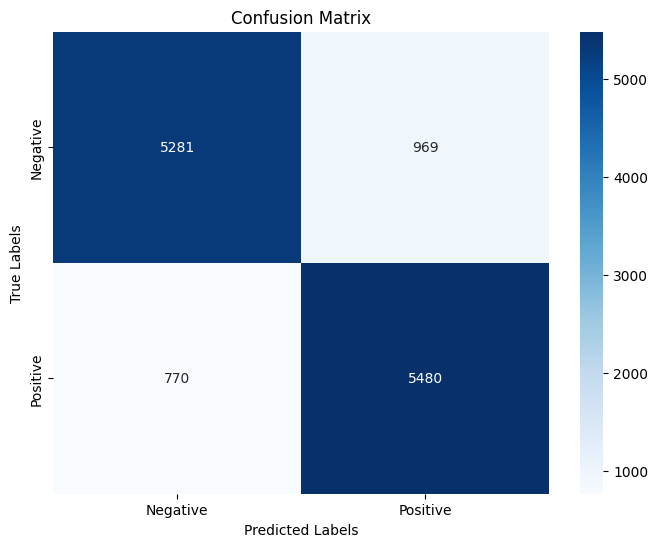

In [102]:
from sklearn.metrics import confusion_matrix,roc_curve
import numpy as np
import seaborn as sns

conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

# Plot Confusion Matrix as a Heatmap
class_names = ['Negative', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()